### pyTorch 를 비롯해 오늘 실습에 필요한 파이썬 라이브러리를 읽어들입니다.

### Copyright (C) 2018  Cheonbok Park <cb_park@korea.ac.kr> and Keetae Park()

In [0]:
import torch
import torch.nn as nn #
import torch.nn.functional as F #
import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다. 
import torchvision.datasets as vision_dsets
import torchvision.transforms as transforms # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt # 시각화를 위한 패키지입니다.

### Hyper-parameter 세팅 및 기타 변수 지정

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # pytorch0.4.0 이상 버젼에서 gpu 설정하는 방식, tensor.to(device) 이런식으로 사용
lr = 0.001
batch_size = 128
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

### 다양한 함수 연습

In [0]:
# torch.view 연습

sample = torch.randn(2000,64,64,3)
# sample => (2000, 64, 64, 3).  
sample_1 = sample.view(2000, -1) #위 sample 을 (2000, 64*64*3)으로 바꿔보세요.
sample_2 = sample.view(2000*64, -1) #위 sample 을 (2000*64, 64*3)로 바꿔보세요.
print(sample_1.size())
print(sample_2.size())

torch.Size([2000, 12288])
torch.Size([128000, 192])


In [0]:
# torch.view 다른 예제
a = torch.FloatTensor(5,20,100)
a1 = a.view(2, 10, -1)
print(a1.size())
a2 = a.view(-1,10, 200)
print(a2.size())

torch.Size([2, 10, 500])
torch.Size([5, 10, 200])


### Convolution layer  가지고 놀기 

In [0]:
# torch.nn.conv 연습
# 클래스 구성: nn.Conv2d(in, out, filter_size, stride, padding)
# 아웃풋사이즈가 이와같이 되도록 되도록 해봅니다: (16, 128, 32, 32)
input1 = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3, 512, 3, 1, 1)
conv2 = nn.Conv2d(512,128,3,2,1)

out = conv1(input1)
output = conv2(out)

print(output.size())

torch.Size([16, 128, 32, 32])


In [0]:
# torch.nn.conv 연습
# 클래스 구성: nn.Conv2d(in, out, filter_size, stride, padding)
# 아웃풋사이즈가 이와같이 되도록 해봅니다: (16, 512, 16, 16)
input = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3,64,3,1,1)
conv2 = nn.Conv2d(64,512,3,4,1)

out = conv1(input)
output = conv2(out)

print(output.size())


torch.Size([16, 512, 16, 16])


In [0]:
#quiz 4 (torch.nn.conv 연습)
# 클래스 구성: nn.Conv2d(in, out, filter_size, stride, padding)
# 아웃풋사이즈가 이와같이 되도록 해봅니다: (16, 512, 64, 64)
input = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3,64,3,1,1)
conv2 = nn.Conv2d(64,512,3,1,1)

out = conv1(input)
output = conv2(out)

print(output.size())


torch.Size([16, 512, 64, 64])


### 데이터 로딩

Data Augmentation?

In [0]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 랜덤 cropping을 하고, 이미지 좌우반전을 해주는 이유 : ???

# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


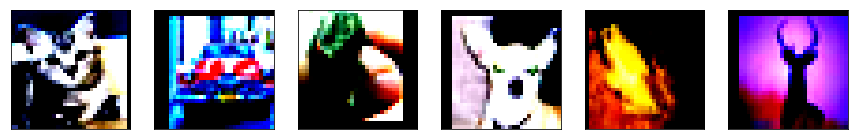

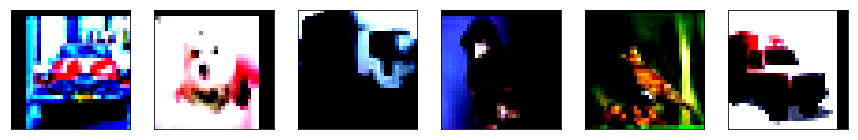

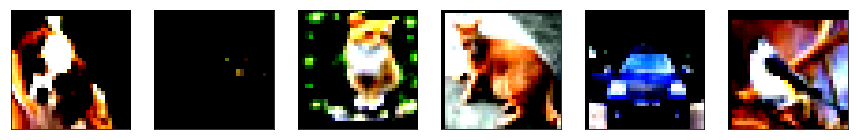

In [0]:
def showImages(image, row):
  
  for _ in range(row):  
  
    idx = np.random.choice(batch_size, 6)     # 0 ~ 127 의 정수 중 6 개를 임의로 선택
    images =image.numpy()[idx].transpose(0,2,3,1).clip(0,1)         # 선택된 index 에 해당하는 이미지를 가져옴
    plt.figure(figsize = (15, 90))     # 세로 길이 15, 가로 길이 15 * 6 의 화면 생성
    
    for i in range(161, 167):    
    
      plt.subplot(i)
      plt.imshow(images[i - 161])
      plt.xticks([])
      plt.yticks([])    
    
    plt.show()  

for i, (image, labels) in enumerate(trainloader): 
  
  showImages(image.squeeze(), 3)
  break

In [0]:
print('[info] # of train batch : ' ,len(trainloader))
print('[info] # of test batch : ', len(testloader))

[info] # of train batch :  391
[info] # of test batch :  100


In [0]:
def train_network(net,optimizer,trainloader, epochs=5):
  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0 # running loss를 저장하기 위한 변수입니다. 
      for i, data in enumerate(trainloader): # 한 Epoch 만큼 돕니다. 매 iteration 마다 정해진 Batch size 만큼 데이터를 뱉습니다. 
          # get the inputs
          inputs, labels = data # DataLoader iterator의 반환 값은 input_data 와 labels의 튜플 형식입니다. 
          inputs = inputs.to(device) # Pytorch에서 nn.Module 에 넣어 Backprop을 계산 하기 위해서는 gpu 연동을 이와 같이 해줘야 합니다.
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()    #  현재 기존의 backprop을 계산하기 위해서 저장했던 activation buffer 를 비웁니다.
          # forward + backward + optimize
          outputs = net(inputs) # input 을 넣은 위 network 로 부터 output 을 얻어냅니다. 
          loss = criterion(outputs, labels) # loss fucntion에 주어진 target과 output 의 score를 계산하여 반환합니다. 
          loss.backward() # * Scalar Loss value를 Backward() 해주게 되면 주어진 loss값을 바탕으로 backpropagation이 진행됩니다. 
          optimizer.step() # 계산된 Backprop 을 바탕으로 optimizer가 gradient descenting 을 수행합니다. 

          # print statistics
          running_loss += loss.item()
          if (i+1) % 100 == 0:    # print every 500 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
              running_loss = 0.0

  print('Finished Training')

In [0]:
def test(model,test_loader):
  model.eval() # Eval Mode 왜 해야 할까요?  --> nn.Dropout BatchNorm 등의 Regularization 들이 test 모드로 들어가게 되기 때문입니다. 
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)  # 기존의 train function의 data 처리부분과 같습니다. 
    output = model(data) 
    pred = output.max(1, keepdim=True)[1] # get the index of the max 
    correct += pred.eq(target.view_as(pred)).sum().item() # 정답 데이터의 갯수를 반환합니다. 

  test_loss /= len(test_loader.dataset)
  print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
def count_parameters(model): # 모델 파라미터 개수를 리턴하는 함수를 하나 만들어둡니다
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

### MNIST에서 사용했던 MLP를 적용해보자!

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        
        layer_list = [] # 이 리스트에 모든 Layer 를 순차적으로 append 해보겠습니다. 
        layer_list.append(nn.Linear(3*32*32,256)) #Layer 1 인풋 사이즈가 32*32로 변경되었기 때문에 바꿔줍니다!!
        layer_list.append(nn.BatchNorm1d(256))#BatchNorm1
        layer_list.append(nn.ReLU()) # Relu 
        layer_list.append(nn.Linear(256, 64)) # Layer 2
        layer_list.append(nn.BatchNorm1d(64)) #BatchNorm1
        layer_list.append(nn.ReLU())# Relu 
        layer_list.append(nn.Linear(64, 10)) # Layer 3
        self.net  = nn.Sequential(*layer_list) # nn.Sequential 에 layer list를 넘겨 줍니다.
        
    def forward(self, x):
        x = x.view(-1,32*32*3)
        x = self.net(x) # 넣은 순서대로 적용이 됩니다. 
        return x

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(mnist_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [0]:
train_network(mnist_net,optimizer,trainloader)

[1,   100] loss: 2.034
[1,   200] loss: 1.835
[1,   300] loss: 1.739
[2,   100] loss: 1.651
[2,   200] loss: 1.617
[2,   300] loss: 1.616
[3,   100] loss: 1.561
[3,   200] loss: 1.555
[3,   300] loss: 1.541
[4,   100] loss: 1.518
[4,   200] loss: 1.507
[4,   300] loss: 1.500
[5,   100] loss: 1.473
[5,   200] loss: 1.470
[5,   300] loss: 1.476
Finished Training


In [0]:
test(mnist_net,testloader)


Test set:  Accuracy: 5070/10000 (51%)



### 심플한 CNN 모델을 만들어 봅시다.

<구성>

Layer 1 - input: 3 x 32 x 32, output: 64 x 32 x 32- ReLU + BatchNorm

Layer 2 - input: 64 x 32 x 32, output: 128 x 16 x 16- ReLU + BatchNorm (Down Conv라고 부릅니다.)

Layer 5 - Global Average Pooling (128 x 16 x 16 => 128 x 1 x 1)

Layer 6 - input: 128 x 1 x 1, output 10 x 1 x 1 - ReLU + BatchNorm

![대체 텍스트](https://cdn-images-1.medium.com/max/1600/1*D47ER7IArwPv69k3O_1nqQ.png)

In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=??, out_channels=??, kernel_size=7, stride=1, padding=3)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(??)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(??, 128, 5, 2, 1)]
    layers += [nn.BatchNorm2d(??)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(??, 256, 5, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(??, ??, 5, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)]
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)]
    
    self.main = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

SyntaxError: ignored

##### 정답: 자신을 위해 가능한 확인하지 않고 진행해주세요~

In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64, 128, 3, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 3, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 3, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)]
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)]
    
    self.main = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

print('[info] number of model parameter - %d'%(count_parameters(cifar_net))) # 방금 구성한 모형의 파라미터 개수를 프린트 해봅니다.

[info] number of model parameter - 1558026


In [0]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.743
[1,   200] loss: 1.491
[1,   300] loss: 1.371
[2,   100] loss: 1.216
[2,   200] loss: 1.172
[2,   300] loss: 1.116
[3,   100] loss: 1.029
[3,   200] loss: 1.017
[3,   300] loss: 1.006
[4,   100] loss: 0.934
[4,   200] loss: 0.919
[4,   300] loss: 0.904
[5,   100] loss: 0.844
[5,   200] loss: 0.843
[5,   300] loss: 0.834
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7263/10000 (73%)



### Average Pooling 대신 Linear Layer로!

In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64, 128, 3, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 3, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 3, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    classifier = []
    classifier += [nn.Linear(512*4,512)]
    
    classifier += [nn.Linear(512,10)]
    
    
    
    self.main = nn.Sequential(*layers)
    self.classifier = nn.Sequential(*classifier)
    
  def forward(self, x):
    out = self.main(x)
    out = out.view(out.size(0),-1)
    out = self.classifier(out)
    return out

In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

print('[info] number of model parameter - %d'%(count_parameters(cifar_net))) # 방금 구성한 모형의 파라미터 개수를 프린트 해봅니다.

[info] number of model parameter - 2607114


In [0]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.771
[1,   200] loss: 1.506
[1,   300] loss: 1.381
[2,   100] loss: 1.238
[2,   200] loss: 1.152
[2,   300] loss: 1.116
[3,   100] loss: 1.016
[3,   200] loss: 0.973
[3,   300] loss: 0.962
[4,   100] loss: 0.882
[4,   200] loss: 0.875
[4,   300] loss: 0.868
[5,   100] loss: 0.803
[5,   200] loss: 0.809
[5,   300] loss: 0.786
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7410/10000 (74%)



### 데이터 intialization

In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64, 128, 3, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 3, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 3, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)]
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)]
    
    self.main = nn.Sequential(*layers)
    self._reset_params()
  def _reset_params(self):
    for i,layer in enumerate(self.main):
      if type(layer) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(layer.weight.data)
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다.

In [0]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.728
[1,   200] loss: 1.484
[1,   300] loss: 1.384
[2,   100] loss: 1.225
[2,   200] loss: 1.168
[2,   300] loss: 1.131
[3,   100] loss: 1.045
[3,   200] loss: 1.022
[3,   300] loss: 1.006
[4,   100] loss: 0.934
[4,   200] loss: 0.920
[4,   300] loss: 0.909
[5,   100] loss: 0.862
[5,   200] loss: 0.851
[5,   300] loss: 0.832
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7350/10000 (74%)



weight intialization은 효과가 있었나요?

### 데이터 전처리를 한번 없애면 성능은 어떻게 변할까요?

In [0]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
   
    transforms.ToTensor(),
     
])



# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
   # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [0]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.588
[1,   200] loss: 1.283
[1,   300] loss: 1.159
[2,   100] loss: 0.932
[2,   200] loss: 0.915
[2,   300] loss: 0.868
[3,   100] loss: 0.695
[3,   200] loss: 0.699
[3,   300] loss: 0.710
[4,   100] loss: 0.518
[4,   200] loss: 0.527
[4,   300] loss: 0.561
[5,   100] loss: 0.352
[5,   200] loss: 0.385
[5,   300] loss: 0.422
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 6834/10000 (68%)



Q) 왜 성능이 낮아졌을까요?

### 데이터 shuffling 의 효과

In [0]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 랜덤 cropping을 하고, 이미지 좌우반전을 해주는 이유 : ???

# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [0]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.739
[1,   200] loss: 1.488
[1,   300] loss: 1.375
[2,   100] loss: 1.219
[2,   200] loss: 1.155
[2,   300] loss: 1.113
[3,   100] loss: 1.037
[3,   200] loss: 1.013
[3,   300] loss: 0.986
[4,   100] loss: 0.927
[4,   200] loss: 0.913
[4,   300] loss: 0.895
[5,   100] loss: 0.850
[5,   200] loss: 0.834
[5,   300] loss: 0.831
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7224/10000 (72%)



Q) Shuffling 을 제거 했더니 성능이 어떻게 변하나요?  shuffling 은 왜 중요할까요?

### 다시 원래 옵션으로 되돌립니다.

In [0]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 랜덤 cropping을 하고, 이미지 좌우반전을 해주는 이유 : ???

# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64, 128, 3, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 3, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 3, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)]
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)]
    
    self.main = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

### Learning rate scheduler를 도입합니다. 

In [0]:
def train_network2(net,optimizer,trainloader, scheduler, epochs=5):
  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0 # running loss를 저장하기 위한 변수입니다. 
      for i, data in enumerate(trainloader): # 한 Epoch 만큼 돕니다. 매 iteration 마다 정해진 Batch size 만큼 데이터를 뱉습니다. 
          # get the inputs
          inputs, labels = data # DataLoader iterator의 반환 값은 input_data 와 labels의 튜플 형식입니다. 
          inputs = inputs.to(device) # Pytorch에서 nn.Module 에 넣어 Backprop을 계산 하기 위해서는 gpu 연동을 이와 같이 해줘야 합니다.
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()    #  현재 기존의 backprop을 계산하기 위해서 저장했던 activation buffer 를 비웁니다.
          # forward + backward + optimize
          outputs = net(inputs) # input 을 넣은 위 network 로 부터 output 을 얻어냅니다. 
          loss = criterion(outputs, labels) # loss fucntion에 주어진 target과 output 의 score를 계산하여 반환합니다. 
          loss.backward() # * Scalar Loss value를 Backward() 해주게 되면 주어진 loss값을 바탕으로 backpropagation이 진행됩니다. 
          optimizer.step() # 계산된 Backprop 을 바탕으로 optimizer가 gradient descenting 을 수행합니다. 

          # print statistics
          running_loss += loss.item()
          if (i+1) % 100 == 0:    # print every 500 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
              running_loss = 0.0
      scheduler.step() 
  print('Finished Training')

In [0]:
from torch.optim.lr_scheduler import MultiStepLR
scheduler = MultiStepLR(optimizer, milestones=[2,4], gamma=0.5)# learning rate을 0.1에서 시작해서 1에폭마다 1/10로 줄여보겠습니다.
cifar_net = DiyCNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(cifar_net.parameters(), lr=0.001) # 초반 learning rate이 0.1입니다

print('[info] number of model parameter - %d'%(count_parameters(cifar_net))) # 방금 구성한 모형의 파라미터 개수를 프린트 해봅니다.

[info] number of model parameter - 1558026


In [0]:
train_network2(cifar_net,optimizer,trainloader, scheduler, epochs=5)

[1,   100] loss: 1.739
[1,   200] loss: 1.464
[1,   300] loss: 1.348
[2,   100] loss: 1.214
[2,   200] loss: 1.144
[2,   300] loss: 1.133
[3,   100] loss: 1.031
[3,   200] loss: 1.030
[3,   300] loss: 0.987
[4,   100] loss: 0.951
[4,   200] loss: 0.918
[4,   300] loss: 0.902
[5,   100] loss: 0.844
[5,   200] loss: 0.835
[5,   300] loss: 0.840
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7287/10000 (73%)



### Pre-trained 모형 가지고 와서 성능 확인하기 (Transfer Learning 관점)

In [0]:
import torchvision.models as models
vgg_model = models.vgg19_bn(pretrained=True).to(device) # 기존에 만들어진 vgg network 을 이미지넷 데이터에 트레이닝해둔 파라미터를 그대로 받아옵니다.

In [0]:
class DiyCNN(nn.Module):
    def __init__(self, vgg_model):
        super(DiyCNN, self).__init__()
        self.pre_trained = nn.Sequential(   
            *list(vgg_model.features.children())
        )
        self.mlp = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        out = self.pre_trained(x).squeeze()
        out = self.mlp(out)
        return out

In [0]:
cifar_net = DiyCNN(vgg_model).to(device)
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

print('[info] number of model parameter - %d'%(count_parameters(cifar_net))) # 방금 구성한 모형의 파라미터 개수를 프린트 해봅니다.

[info] number of model parameter - 20365002


In [0]:
train_network(cifar_net,optimizer,trainloader, epochs=1)

[1,   100] loss: 1.405
[1,   200] loss: 0.970
[1,   300] loss: 0.827
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7699/10000 (77%)

